# Pulse heating for water quality sensing 

## Load libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import matplotlib.dates as mdates
from datetime import datetime
from scipy.signal import find_peaks
from scipy.interpolate import interp1d


%matplotlib ipympl


def find_nearest(lst, target):
    return min(lst, key=lambda x: abs(x - target))
    
class measurCls:
  def __init__(self, csvFile, gasId=0):
    self.csvFile = csvFile
    self.gasId = gasId
    self.pulseSampleSize = 0

def yyStacking(ary1D, insertCol):
    num_rows = len(ary1D)
    ary2D = np.zeros((num_rows, len(gasIdMap)), dtype=int)
    ary2D[:, insertCol] = ary1D
    return ary2D
# ary1D = [1,2]
# ary2D = yyStacking(ary1D, insertCol)
# print(ary2D)

In [8]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices())

TensorFlow version: 2.17.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
gasIdMap = {
    0: 'water',
    1: 'acetone',
    2: 'toluene',
    #3: 'benzene',
}

pltClr = {
    0:'#66ccff',
    1:'#cc0000',
    2:'#009900',
    #3:'#cc00cc',
}

len(gasIdMap),len(pltClr)

(3, 3)

## Read csv

In [4]:
myMeas = measurCls('defbuffer0807 2245.csv', 1) #'acetone'

In [16]:
myMeas = measurCls('defbuffer0808 1600.csv', 2) #'toluene'

In [76]:
myMeas = measurCls('defbuffer0809 1400.csv', 3) #'benzene'

In [4]:
myMeas = measurCls('defbuffer0820 1900.csv', 3) #'acetone, benzene'

In [5]:
df=pd.read_csv('data/'+myMeas.csvFile, skiprows=7)
df = df.reset_index().drop('index', axis=1)
#df['Diff'] = df['Reading'].diff()

df['datetime'] = pd.to_datetime(df['Date']+' '+df['Time'], format='%m/%d/%Y %H:%M:%S')
dummyStartDay = str(df['datetime'][0].year)+'/'+str(df['datetime'][0].month)+'/'+str(df['datetime'][0].day) #'1996/05/22'
df['datetime'] = df['datetime']-df['datetime'][0]+pd.to_datetime(dummyStartDay) + pd.to_timedelta(df['Fractional Seconds'], unit='s')#+pd.Timedelta(hours=24)
df['conv'] = df['Reading'].diff() # 
#df['conv'] =np.convolve(-df['Reading'], np.array([-1,-2,-3,-4,0,4,3,2,1]), mode='same')
startPeaks, _ = find_peaks(-df['conv'], distance=200)
startPeaks = startPeaks
# Scan the peak!!!! Double check 
for i,peak in np.ndenumerate(startPeaks[:]):
    #print(i[0],'\t', startPeaks[i[0]], df[df['Reading']==df.iloc[startPeaks[i[0]]-3:startPeaks[i[0]]]['Reading'].max()].index.tolist(), end='\t')
    newPeak = find_nearest(df[df['Reading'] == df.iloc[startPeaks[i[0]]-3:startPeaks[i[0]]]['Reading'].max()].index.tolist(), peak)
    startPeaks[i[0]] = newPeak#df[df['Reading'] == df.iloc[startPeaks[i[0]]-3:startPeaks[i[0]]]['Reading'].max()].index.tolist()[0]
    #print(startPeaks[i[0]])

In [7]:
df

,Index,Reading,Unit,Range Digits,Disp Digits,Math,Start Group,Limit1 High,Limit1 Low,Limit2 High,...,Digits,Output,Sense,Source Limit,Overtemp,Date,Time,Fractional Seconds,datetime,conv
0,1,998.972207,Ohm,1000,5.5,F,F,F,F,F,...,1,T,2W,F,F,08/07/2024,22:13:40,0.344185,2024-08-07 00:00:00.344184500,NaN
1,2,999.084896,Ohm,1000,5.5,F,F,F,F,F,...,1,T,2W,F,F,08/07/2024,22:13:40,0.426858,2024-08-07 00:00:00.426858420,0.112689
2,3,998.993085,Ohm,1000,5.5,F,F,F,F,F,...,1,T,2W,F,F,08/07/2024,22:13:40,0.509521,2024-08-07 00:00:00.509520520,-0.091811
3,4,999.074092,Ohm,1000,5.5,F,F,F,F,F,...,1,T,2W,F,F,08/07/2024,22:13:40,0.592176,2024-08-07 00:00:00.592175980,0.081007
4,5,999.171732,Ohm,1000,5.5,F,F,F,F,F,...,1,T,2W,F,F,08/07/2024,22:13:40,0.674815,2024-08-07 00:00:00.674815320,0.097640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76158,76159,686.762549,Ohm,1000,5.5,F,F,F,F,F,...,1,T,2W,T,F,08/07/2024,23:59:49,0.492518,2024-08-07 01:46:09.492518480,0.292190
76159,76160,687.098001,Ohm,1000,5.5,F,F,F,F,F,...,1,T,2W,T,F,08/07/2024,23:59:49,0.575182,2024-08-07 01:46:09.575181580,0.335451
76160,76161,687.373555,Ohm,1000,5.5,F,F,F,F,F,...,1,T,2W,T,F,08/07/2024,23:59:49,0.657842,2024-08-07 01:46:09.657841620,0.275554
76161,76162,687.724824,Ohm,1000,5.5,F,F,F,F,F,...,1,T,2W,T,F,08/07/2024,23:59:49,0.740489,2024-08-07 01:46:09.740488960,0.351269


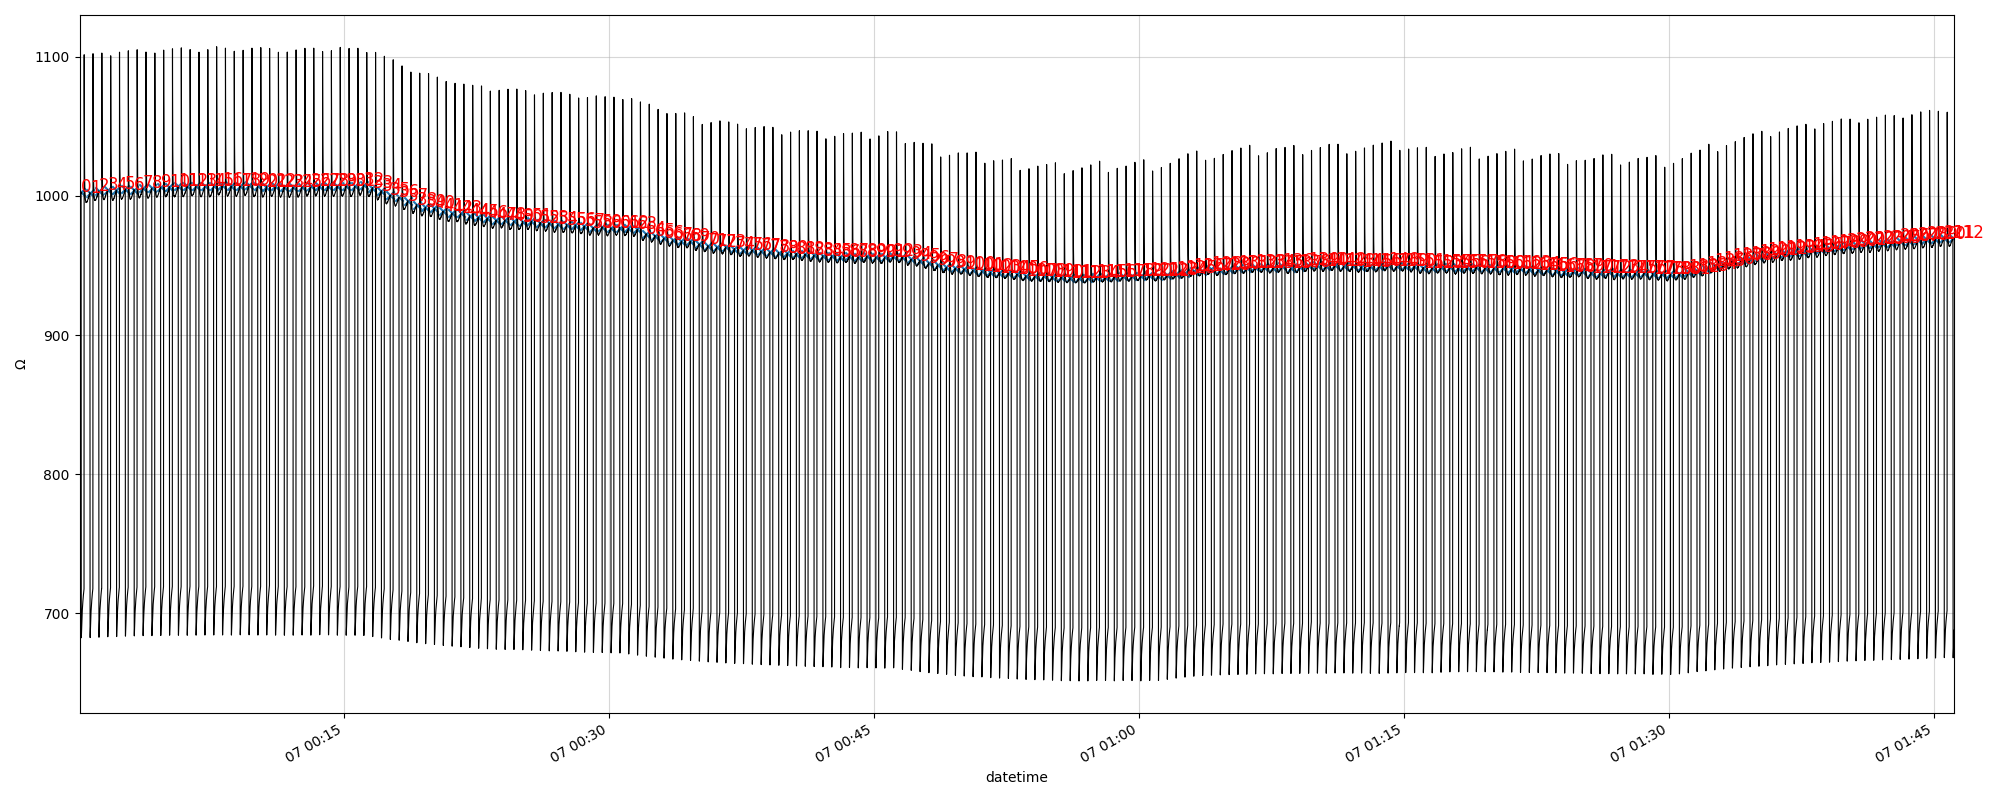

In [6]:

plt.close('all')
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,8))

thisAx=ax

df.plot(ax=thisAx, x ="datetime", y=["Reading"], lw=0.8, color='black')
thisAx.scatter(df['datetime'].iloc[startPeaks], df['Reading'].iloc[startPeaks], marker='x')
for i, txt in enumerate(startPeaks):
    thisAx.text(df['datetime'].iloc[startPeaks[i]],df['Reading'].iloc[startPeaks[i]], i, fontsize=12, color='red')
thisAx.set_ylabel('$\Omega$')
# thisAx.grid(which='minor', alpha=0.3)
# thisAx.grid(which='major', alpha=0.5)
# thisAx.yaxis.set_major_locator(MultipleLocator(100))
#thisAx.xaxis.set_major_locator(MultipleLocator(1/(4*24)))
#thisAx.legend().set_visible(False)
#thisAx.set_xticklabels([])
#thisAx.set_xlim(df['datetime'][0], df['datetime'].iloc[-1]) #df.head(1).index[0]


#thisAx=ax[1]
#thisAx=thisAx.twinx()
#df.plot(ax=thisAx, x ="datetime", y=["conv"], lw=0.2, color='red')
#thisAx.scatter(df['datetime'].iloc[startPeaks], df['conv'].iloc[startPeaks], marker='o')
thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)
# thisAx.yaxis.set_major_locator(MultipleLocator(100))
#thisAx.xaxis.set_major_locator(MultipleLocator(1/(4*24)))
thisAx.legend().set_visible(False)
#thisAx.set_xticklabels([])
thisAx.set_xlim(df['datetime'][0], df['datetime'].iloc[-1]) #df.head(1).index[0]
fig.tight_layout()

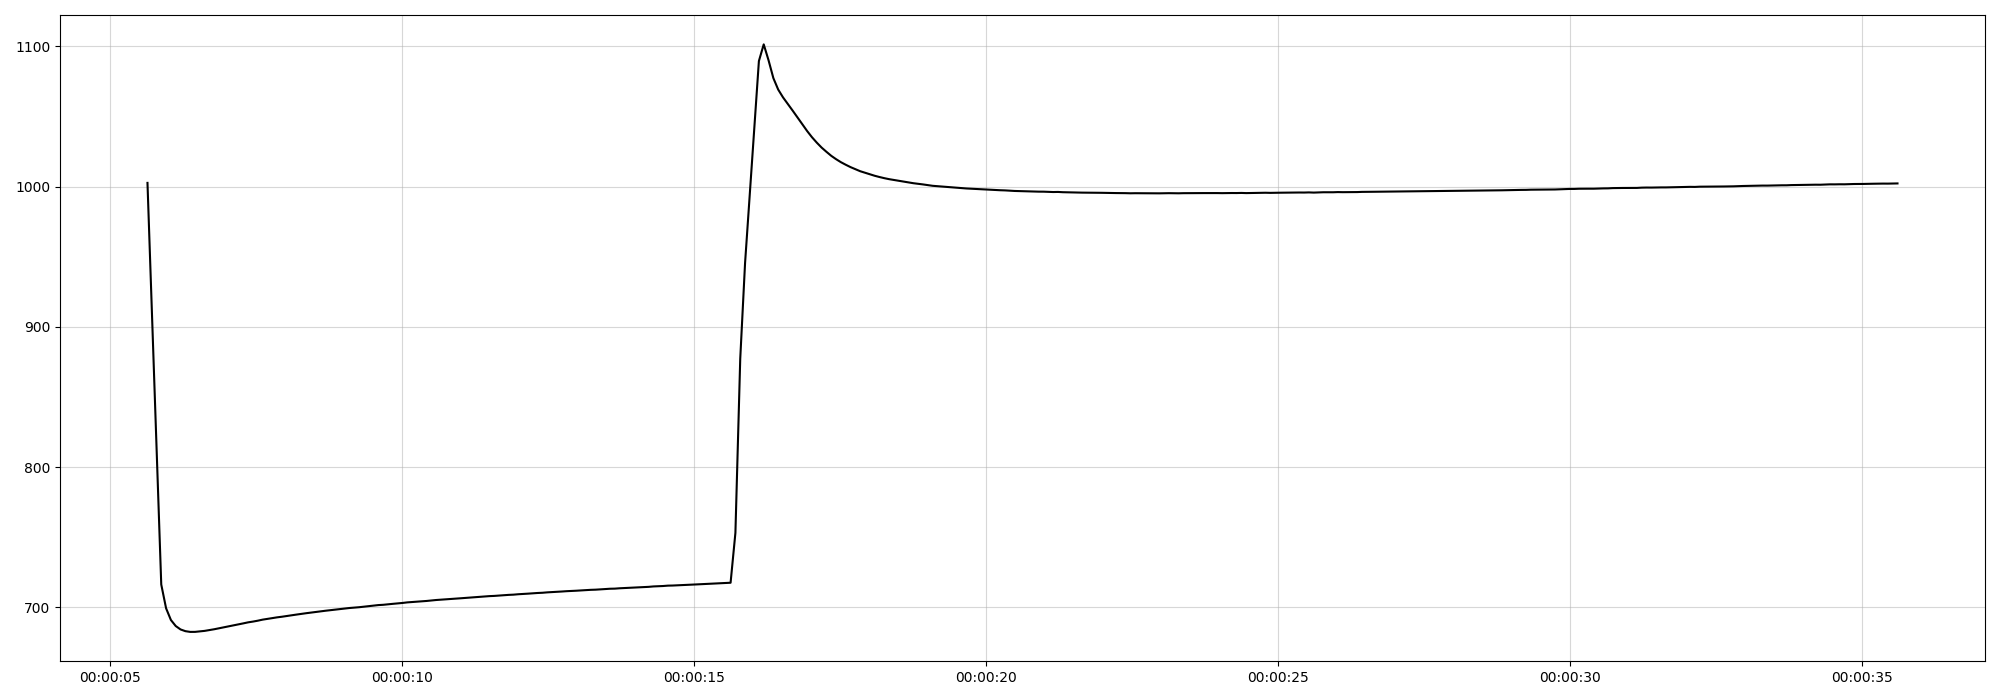

In [67]:

plt.close('all')
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,7))

thisAx=ax
n = 0
noPulse = 1
for n in range(noPulse):
    pulseRang = np.linspace(startPeaks[n], startPeaks[n+1], startPeaks[n+1]-startPeaks[n], dtype = int)
    thisAx.plot(df['datetime'].iloc[pulseRang], df['Reading'].iloc[pulseRang], color='black', alpha = 1)

thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)
# thisAx.yaxis.set_major_locator(MultipleLocator(100))
#thisAx.xaxis.set_major_locator(MultipleLocator(1/(4*24)))

#thisAx.set_xticklabels([])

#thisAx.set_xlim(df['datetime'][0], df['datetime'].iloc[1000]) #df.head(1).index[0]

fig.tight_layout()

### Setup training signal

In [45]:
conc = [0, 200, 400, 600, 400, 200,  0, 0  ]
tVec = [0,  15,  30,  45,  60,  75, 90, 120] #minutes
# conc = [0, 50, 0, 50, 0, 50, 0, 50]
# tVec = [0, 10, 15, 20,25,30, 35,40] #minutes

conc = [item for item in conc for _ in range(2)]
#tVec = [item + 0.1 if i == 1 else item for item in tVec for i in range(2)]
duplicated_list = []
for index, item in enumerate(tVec):
    if index == 0:
        duplicated_list.extend([item, item])
    else:
        duplicated_list.extend([item - 0.1, item])
tVec = duplicated_list[1:] + [duplicated_list[-1]]
print(conc)
print(tVec)
print(len(conc), len(tVec))

[0, 0, 50, 50, 0, 0, 50, 50, 0, 0, 50, 50, 0, 0, 50, 50]
[0, 9.9, 10, 14.9, 15, 19.9, 20, 24.9, 25, 29.9, 30, 34.9, 35, 39.9, 40, 40]
16 16


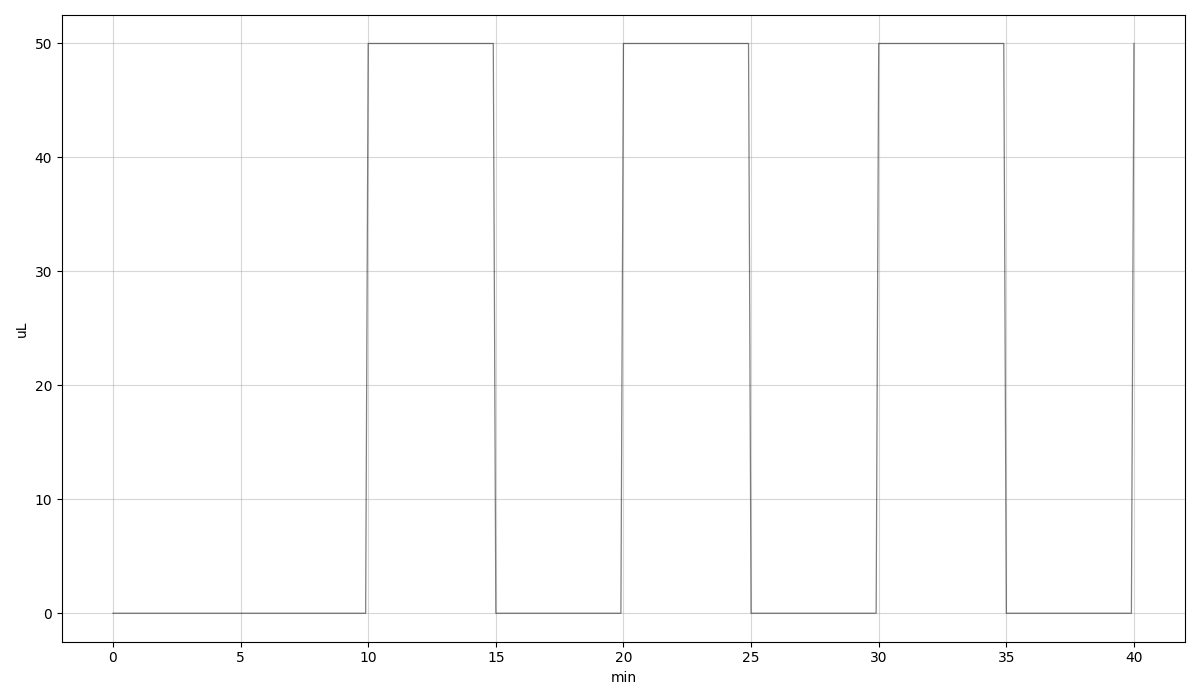

In [46]:
plt.close('all')
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,7))
thisAx = ax
#thisAx.plot(conc, color='black', lw=0.9, alpha = .5,)
thisAx.plot(tVec, conc, color='black', lw=0.9, alpha = .5,)

thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)
thisAx.set_ylabel('uL')
thisAx.set_xlabel('min')
fig.tight_layout()

In [47]:
tVec = [step*60 for step in tVec] #1Hz
new_time_points = np.arange(0, tVec[-1], 30)
new_time_points

array([   0,   30,   60,   90,  120,  150,  180,  210,  240,  270,  300,
        330,  360,  390,  420,  450,  480,  510,  540,  570,  600,  630,
        660,  690,  720,  750,  780,  810,  840,  870,  900,  930,  960,
        990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290,
       1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560, 1590, 1620,
       1650, 1680, 1710, 1740, 1770, 1800, 1830, 1860, 1890, 1920, 1950,
       1980, 2010, 2040, 2070, 2100, 2130, 2160, 2190, 2220, 2250, 2280,
       2310, 2340, 2370])

In [27]:
# sampPerPulse = 300 #sample per pulse
# testing array
tVec = [step*60 for step in tVec] #1Hz
#print(tVec)
interp_func = interp1d(tVec, conc, kind='linear')
new_time_points = np.arange(0, tVec[-1], 30)
concVec = np.array(interp_func(new_time_points))
print(concVec.shape)

(20,)


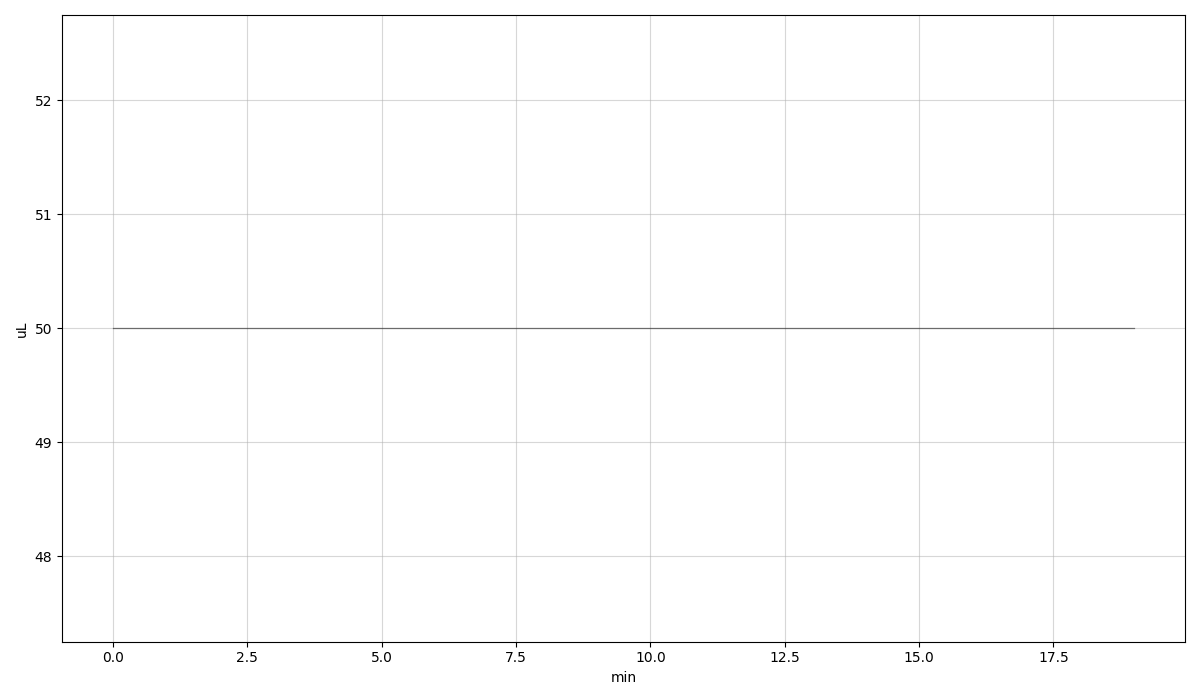

In [28]:
plt.close('all')
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,7))
thisAx = ax
#thisAx.plot(conc, color='black', lw=0.9, alpha = .5,)
thisAx.plot(concVec, color='black', lw=0.9, alpha = .5,)

thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)
thisAx.set_ylabel('uL')
thisAx.set_xlabel('min')
fig.tight_layout()

### Resample to 10Hz

In [17]:
from scipy.interpolate import interp1d
sampPerPulse = 300 #sample per pulse
xx = np.empty((0, sampPerPulse)) 
#yy = df_ml.conc.to_numpy()
for n in range(startPeaks.size-3):
    pulseRang = np.linspace(startPeaks[n], startPeaks[n+1], startPeaks[n+1]-startPeaks[n], dtype = int)
    orgAry = df['Reading'].iloc[pulseRang].to_numpy()
    interpolation_function = interp1d(np.arange(orgAry.shape[0]), orgAry, kind='linear')
    resampled_array = interpolation_function(np.linspace(0, orgAry.shape[0]-1, xx.shape[1]))
    xx = np.vstack([xx, resampled_array])
print(xx.shape)
yy = concVec[0:xx.shape[0]]
print(yy.shape)

(101, 300)
(20,)


In [18]:
conc[::2]

[0, 50, 0, 50, 0, 50, 0, 50, 0]

In [ ]:
plt.close('all')
fig, ax = plt.subplots(nrows=len(conc[::2]),ncols=1, figsize=(15,30))

for i, concc in enumerate(conc[::2]):
    for pulse in xx[np.where(yy==concc)]:
        thisAx = ax[i]
        thisAx.plot(pulse, color='black', lw=0.5, alpha = .1,)
        thisAx.grid(which='minor', alpha=0.3)
        thisAx.grid(which='major', alpha=0.5)
        thisAx.set_ylabel(str(concc)+'uL'+'\n$\Omega$')
        thisAx.set_xticklabels([])
fig.tight_layout()

In [14]:
# Create New GLOBAL set
xx_pca = np.empty((0, sampPerPulse)) 
yy_pca = np.empty((0, len(gasIdMap))) 
pulseSampleSize = []
print(xx_pca.shape, yy_pca.shape)
#yy_pca = np.empty((0, 1))

(0, 300) (0, 3)


In [24]:
xx_pca = np.vstack([xx_pca, xx])
yy_pca = np.vstack([yy_pca, yyStacking(yy, myMeas.gasId)])

pulseSampleSize.append(xx.shape[0])
print(xx_pca.shape, yy_pca.shape)
print(pulseSampleSize)

(448, 300) (448, 3)
[210, 238]


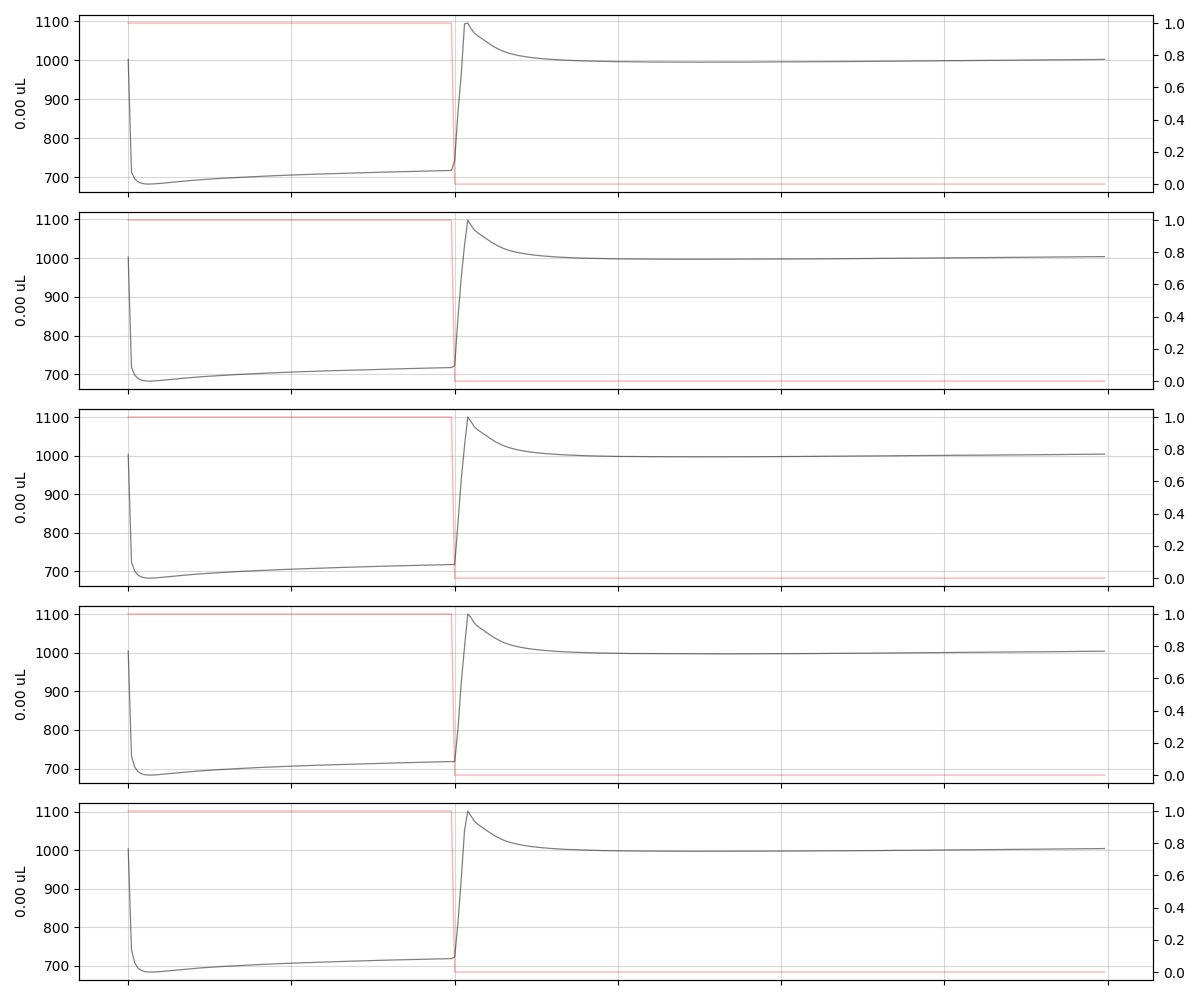

In [549]:
thisAx=ax
n = 0
noPulse = 5
pulseVec = np.concatenate((np.ones(100, dtype=int), np.zeros(200, dtype=int)))
plt.close('all')
fig, ax = plt.subplots(nrows=noPulse,ncols=1, figsize=(12,10))
for n in range(noPulse):
    thisAx = ax[n]
    #pulseRang = np.linspace(startPeaks[n], startPeaks[n+1]-1, startPeaks[n+1]-startPeaks[n], dtype = int)
    thisAx.plot(xx[n], color='black', lw=0.9, alpha = .5,)

    thisAx.grid(which='minor', alpha=0.3)
    thisAx.grid(which='major', alpha=0.5)
    thisAx.set_xticklabels([])
    thisAx.set_ylabel("%.2f" % yy[n]+' uL')
    thisAx=thisAx.twinx()
    thisAx.plot(pulseVec, color='red', lw=1, alpha = 0.3)

fig.tight_layout()

### Resample (df method, old)

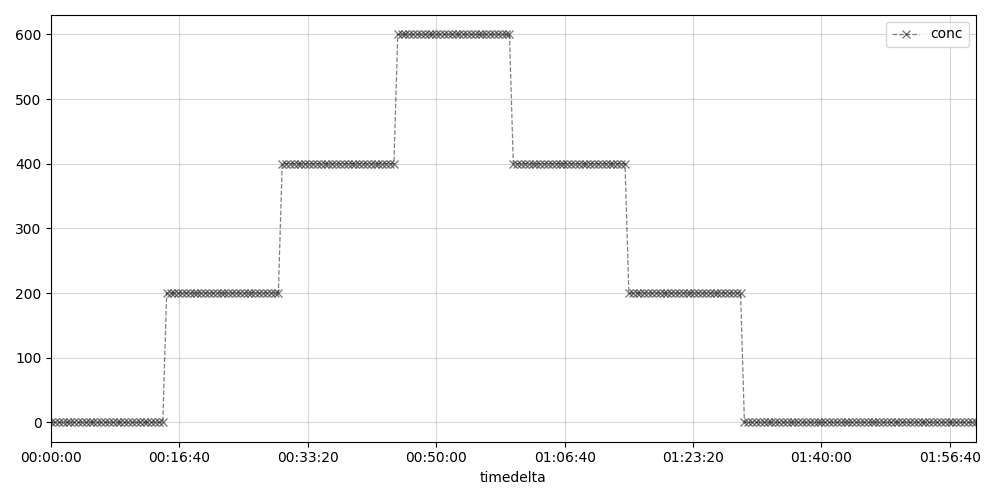

In [27]:
# Setup training data
tVec = ['0', '15', '30', '45', '60', '75', '90', '120']
conc = [0, 200, 400, 600, 400, 200, 0, 0]
df_gt = pd.DataFrame({
    'timedelta': pd.to_timedelta([str(i) + ' minutes' for i in tVec]),
    'conc': conc
})
df_gt.set_index('timedelta', inplace=True)
df_gt = df_gt.resample('30s').ffill() #.interpolate(method='ffill') #linear
#df_gt = df_gt.rolling(5).mean()
df_gt = df_gt.fillna(0)
plt.close('all')
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,5))
thisAx = ax
df_gt.plot(ax=thisAx,y='conc', color='black',style='x--', lw=0.9, alpha = .5)
thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)

#thisAx.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
fig.tight_layout()

AttributeError: 'numpy.ndarray' object has no attribute 'index'

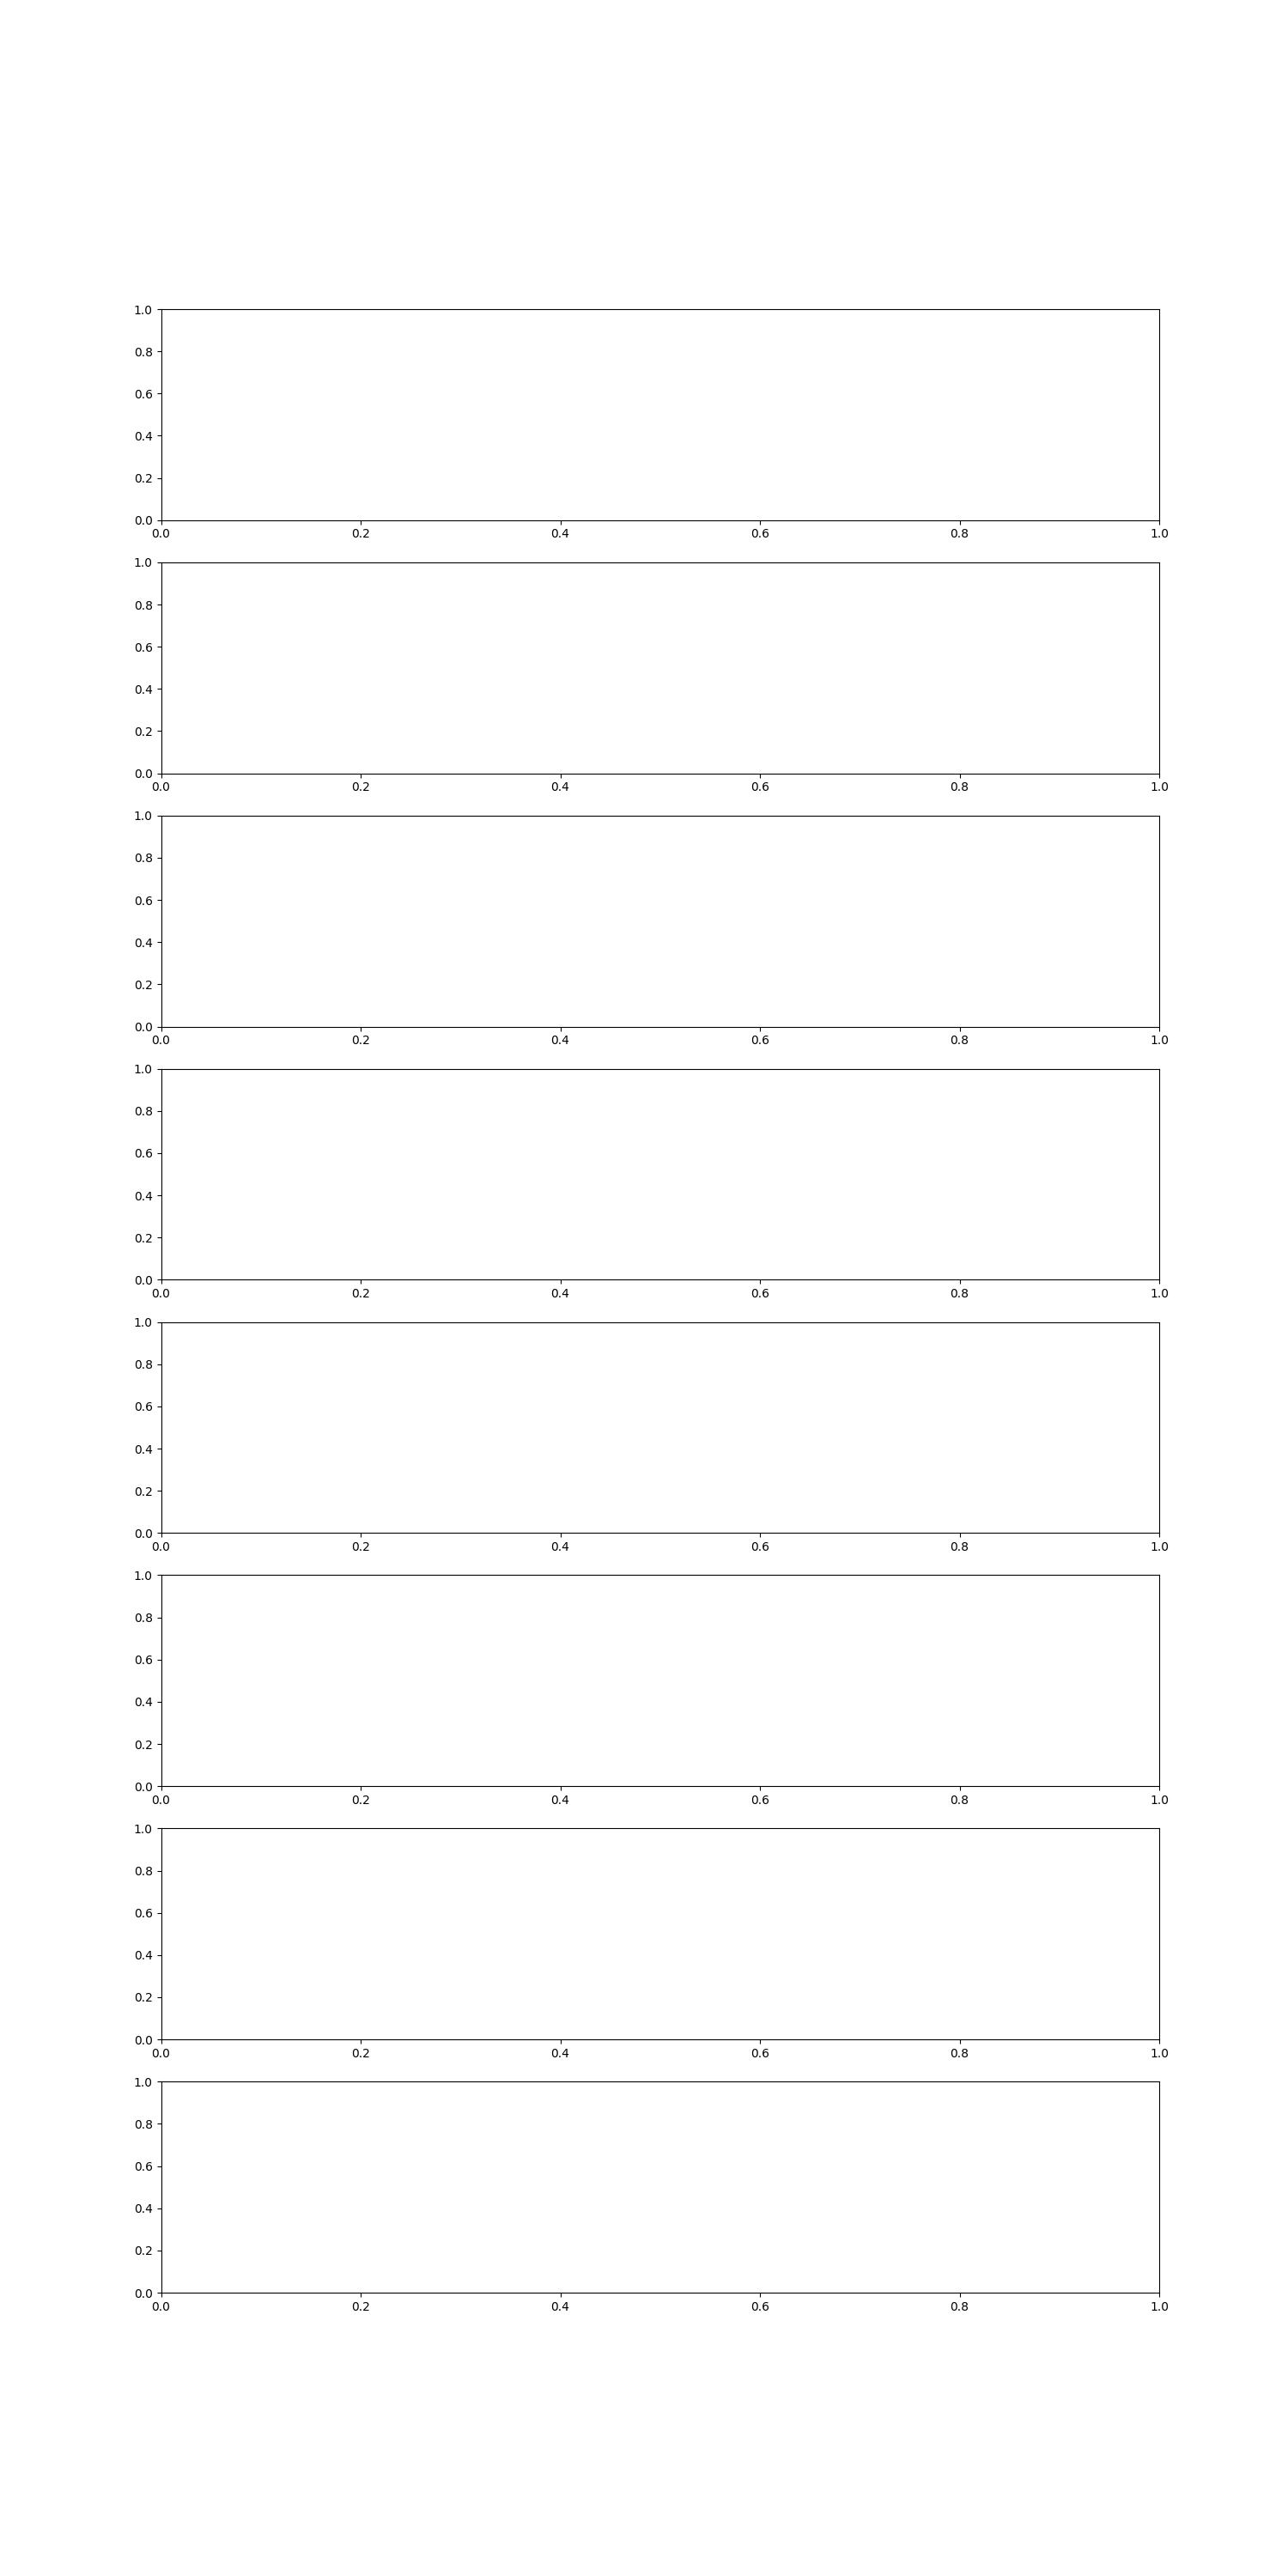

In [30]:
plt.close('all')
fig, ax = plt.subplots(nrows=len(conc),ncols=1, figsize=(15,30))

for i, concc in enumerate(conc):
    thisAx = ax[i]
    #print(df_ml[df_ml['conc']==concc]['pulse'].iloc[0])
    for index, row in df_ml[df_ml['conc']==concc].iterrows():
        thisAx.plot(row['pulse'].index.to_numpy()/10, row['pulse'], color='black', lw=0.9, alpha = .1) #,
        #thisAx.plot(df_ml[df_ml['conc']==concc]['pulse'].iloc[-1], color='black', lw=0.9, alpha = .9,)
    #thisAx.text(20, row['pulse'].min() , str(df_ml[df_ml['conc']==concc]['conc'].iloc[0])+' uL', fontsize=24, color='black', alpha = 0.4)
    #print(i, concc)
    #print(df_ml[df_ml['conc']==concc].conc)
    thisAx.grid(which='minor', alpha=0.3)
    thisAx.grid(which='major', alpha=0.5)
    #thisAx.set_ylabel(str(df_ml[df_ml['conc']==concc]['conc'].iloc[0])+' uL')
    thisAx.set_ylabel('$ \\Omega$')
    thisAx.set_ylim(600, 1200)
    thisAx.set_xlim((row['pulse'].index.to_numpy()/10)[0]-1, (row['pulse'].index.to_numpy()/10)[-1]+1) #df.head(1).index[0]
    if i<len(conc)-1:
        thisAx.set_xticklabels([])
ax[0].set_title('1L DI Water Mixture with '+myMeas.compound)
thisAx.set_xlabel('$Second$')
fig.tight_layout()

In [29]:
df_pulse = []
df_ml = pd.DataFrame()
df_timVec = pd.timedelta_range(start='0 days', periods=startPeaks.size-1, freq='30s')
for n in range(startPeaks.size-2):
    pulseRang = np.linspace(startPeaks[n], startPeaks[n+1], startPeaks[n+1]-startPeaks[n], dtype = int) #
    df_pulse.append(df[['Index', 'Reading', 'datetime']].iloc[pulseRang])
    df_pulse[-1].set_index('datetime', inplace=True)
    df_pulse[-1]=df_pulse[-1].resample('100ms').mean().interpolate(method='linear')[:300]
    df_pulse[-1].Index = np.linspace(0, len(df_pulse[n])-1, len(df_pulse[n]), dtype=int)
    df_ml_col = pd.DataFrame({'timedelta':df_timVec[n], 'pulse':[df_pulse[-1].Reading.to_numpy()], 'conc':df_gt[df_gt.index==df_timVec[n]].conc}) #
    df_ml=pd.concat([df_ml, df_ml_col], ignore_index=True)
df_ml.set_index('timedelta', inplace=True)
df_ml = df_ml.fillna(0)
df_ml

,pulse,conc
timedelta,,
0 days 00:00:00,"[1002.660712424, 859.45428017615, 716.24784792...",0
0 days 00:00:30,"[1002.269839794, 862.1297080467, 721.989576299...",0
0 days 00:01:00,"[1003.571895788, 912.0533537361666, 820.534811...",0
0 days 00:01:30,"[1004.362004027, 915.5941413173333, 826.826278...",0
0 days 00:02:00,"[1004.011078721, 912.9302616628, 821.849444604...",0
...,...,...
0 days 01:43:00,"[967.4346735627, 883.8057257495, 800.176777936...",0
0 days 01:43:30,"[967.4335973322, 847.03906623295, 726.64453513...",0
0 days 01:44:00,"[967.9389665187, 967.8610147601, 967.914899141...",0


300

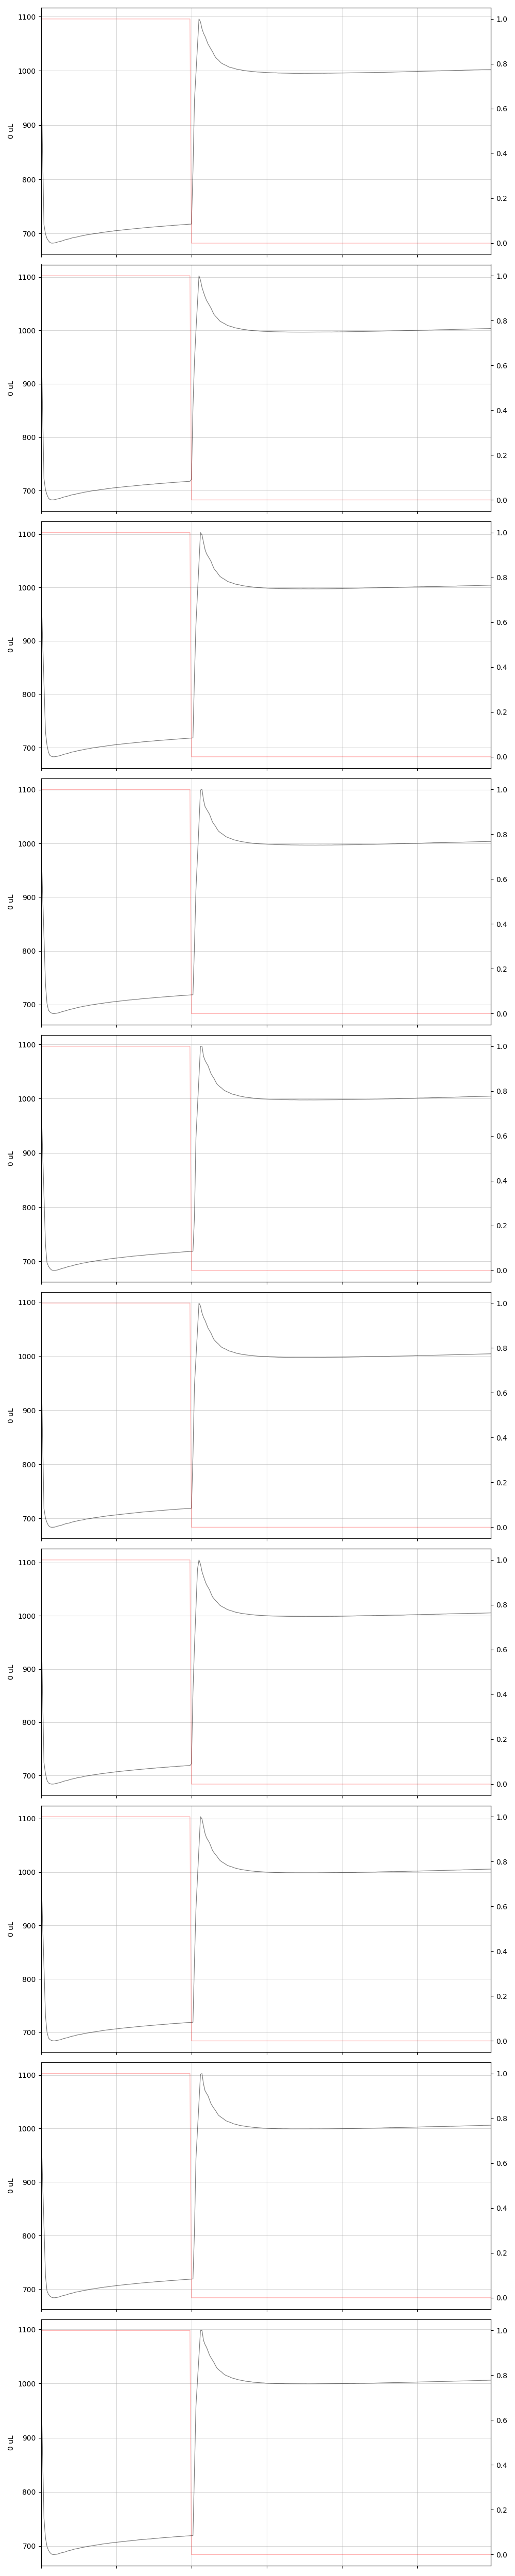

In [31]:
thisAx=ax
n = 0
noPulse = 10
pulseVec = np.concatenate((np.ones(100, dtype=int), np.zeros(200, dtype=int)))
plt.close('all')
fig, ax = plt.subplots(nrows=noPulse,ncols=1, figsize=(10,50))
for n in range(noPulse):
    thisAx = ax[n]
    #pulseRang = np.linspace(startPeaks[n], startPeaks[n+1]-1, startPeaks[n+1]-startPeaks[n], dtype = int)
    thisAx.plot(df_ml.iloc[n]['pulse'], color='black', lw=0.9, alpha = .5,)

    thisAx.grid(which='minor', alpha=0.3)
    thisAx.grid(which='major', alpha=0.5)
    thisAx.set_xlim(df_pulse[n]['Index'].iloc[0], df_pulse[n]['Index'].iloc[-1])
    thisAx.set_xticklabels([])
    thisAx.set_ylabel(str(df_ml.iloc[n]['conc'])+' uL')
    thisAx=thisAx.twinx()
    thisAx.plot(pulseVec, color='red', lw=1, alpha = 0.3)

fig.tight_layout()

AttributeError: 'numpy.ndarray' object has no attribute 'index'

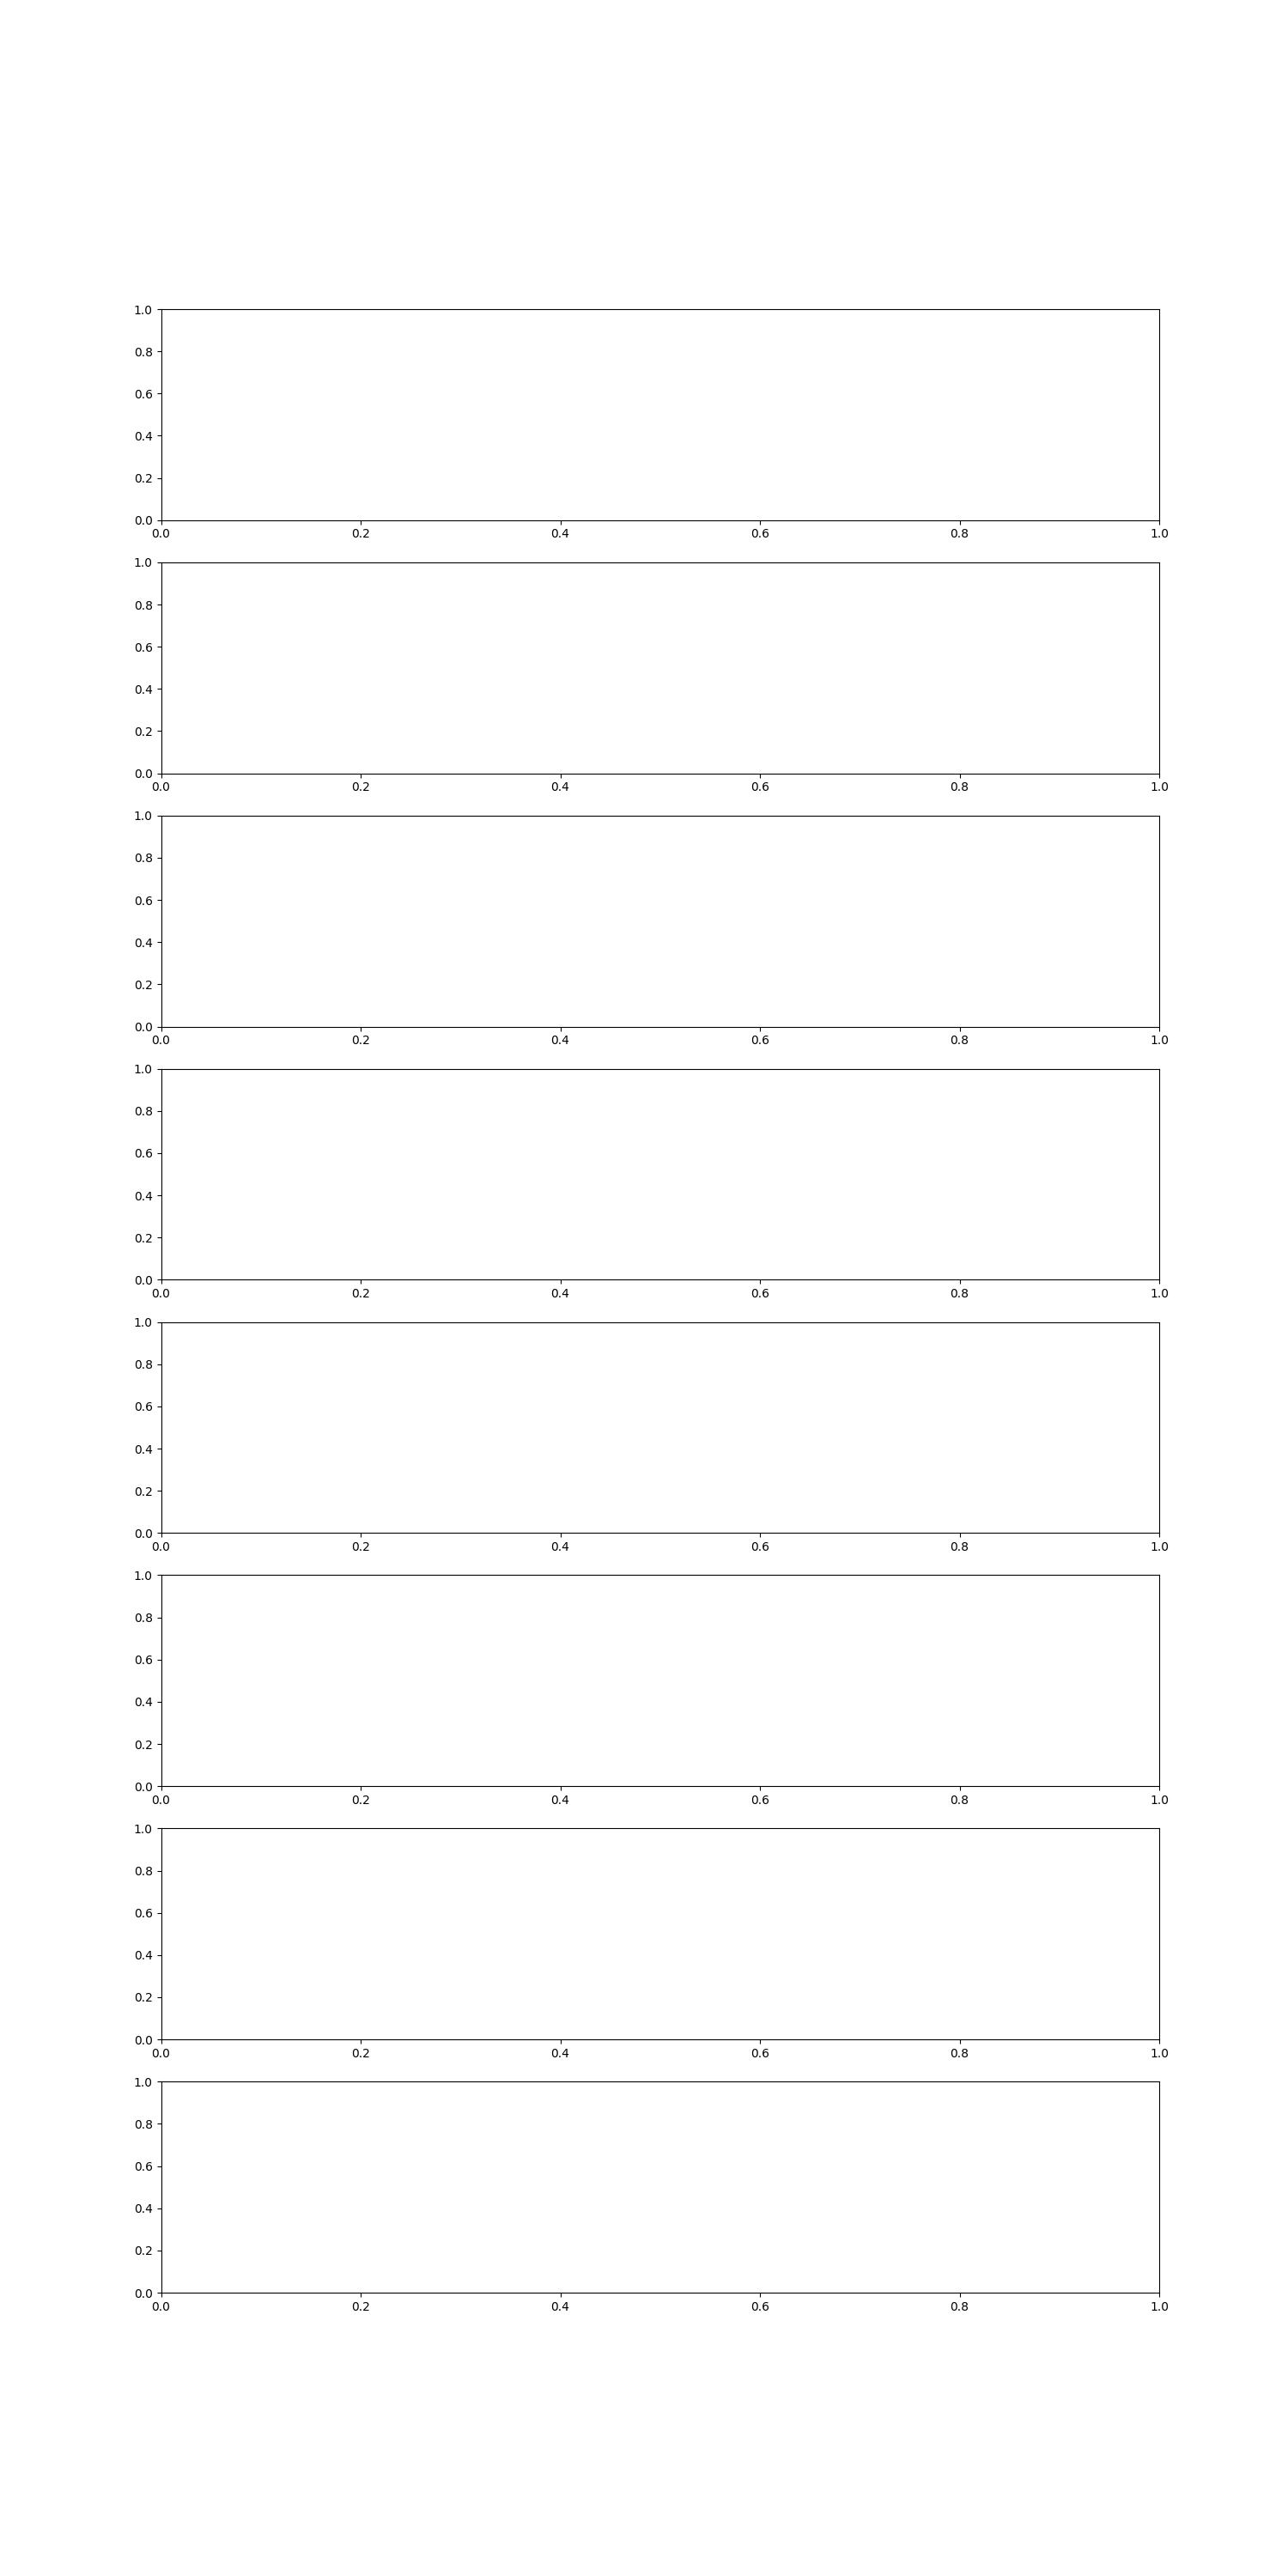

In [33]:
plt.close('all')
fig, ax = plt.subplots(nrows=len(conc),ncols=1, figsize=(15,30))

for i, concc in enumerate(conc):
    thisAx = ax[i]
    #print(df_ml[df_ml['conc']==concc]['pulse'].iloc[0])
    for index, row in df_ml[df_ml['conc']==concc].iterrows():
        thisAx.plot(row['pulse'].index.to_numpy()/10, row['pulse'], color='black', lw=0.9, alpha = .1) #,
        #thisAx.plot(df_ml[df_ml['conc']==concc]['pulse'].iloc[-1], color='black', lw=0.9, alpha = .9,)
    #thisAx.text(20, row['pulse'].min() , str(df_ml[df_ml['conc']==concc]['conc'].iloc[0])+' uL', fontsize=24, color='black', alpha = 0.4)
    #print(i, concc)
    #print(df_ml[df_ml['conc']==concc].conc)
    thisAx.grid(which='minor', alpha=0.3)
    thisAx.grid(which='major', alpha=0.5)
    #thisAx.set_ylabel(str(df_ml[df_ml['conc']==concc]['conc'].iloc[0])+' uL')
    thisAx.set_ylabel('$ \\Omega$')
    thisAx.set_ylim(600, 1200)
    thisAx.set_xlim((row['pulse'].index.to_numpy()/10)[0]-1, (row['pulse'].index.to_numpy()/10)[-1]+1) #df.head(1).index[0]
    if i<len(conc)-1:
        thisAx.set_xticklabels([])
ax[0].set_title('1L DI Water Mixture with '+myMeas.gasId)
thisAx.set_xlabel('$Second$')
fig.tight_layout()

In [59]:
df_ml.to_csv('aceton.csv')

## Classification

### Tensorflow

In [266]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model = Sequential()
model.add(Dense(64, input_shape=(300,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
xx = np.array(df_ml.pulse.apply(lambda row: row[0].to_numpy()))#np.array(df_ml.pulse.apply(lambda row: print(np.array(row[0])))[0])
yy = df_ml.conc.to_numpy()
model.fit(xx, yy, epochs=100, batch_size=32)
predictions = model.predict(xx)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,377 (83.50 KB)

 Trainable params: 21,377 (83.50 KB)

 Non-trainable params: 0 (0.00 B)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [31]:
df_tf.pulse[0].to_numpy()

array([1002.66071242,  859.45428018,  716.24784793,  699.29975401,
        690.92766116,  686.63230354,  683.58538522,  682.44680484,
        682.46764934,  682.81563472,  683.46276371,  684.35146187,
        685.03764756,  685.74507061,  686.4239358 ,  687.46220547,
        688.52327094,  689.26206639,  689.79923865,  690.43592829,
        691.44303603,  692.27191544,  692.82345112,  693.25903207,
        693.78960745,  694.55165202,  695.29462268,  695.76097188,
        696.20926999,  696.9096277 ,  697.52089285,  697.91759768,
        698.32419634,  698.70912924,  699.27915769,  699.7567479 ,
        700.04909164,  700.42956354,  700.75724167,  701.41246419,
        701.77416085,  702.1303621 ,  702.4618896 ,  702.75445408,
        703.29494014,  703.75357644,  704.07118697,  704.2699722 ,
        704.7056974 ,  705.19920734,  705.42959531,  705.72328697,
        705.94700703,  706.28663476,  706.67569891,  706.98023029,
        707.2657994 ,  707.52392655,  707.82935015,  708.10988

In [31]:
yy = df_ml.conc.to_numpy()
xx = np.empty((0, df_ml.pulse[0].size))
for index, row in df_ml.iterrows():
    #print(index, row.pulse.to_numpy().size)
    try:
        xx = np.vstack([xx, row.pulse.to_numpy()])
    except:
        print(index, row.pulse.size)
print(xx.shape)
print(yy.shape)

0 days 00:11:00 299
0 days 01:36:00 299
0 days 01:59:30 182
(237, 300)
(240,)


/tmp/ipykernel_3101/3328407482.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xx = np.empty((0, df_ml.pulse[0].size))


In [30]:
df_ml.iloc[index].conc

TypeError: Cannot index by location index with a non-integer key

In [24]:
xx.shape

(237, 300)

### PCA

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(xx_pca)

In [26]:
reduced_data.shape

(448, 3)

In [27]:
pulseSampleSize

[210, 238]

#### PCA 2D Plot

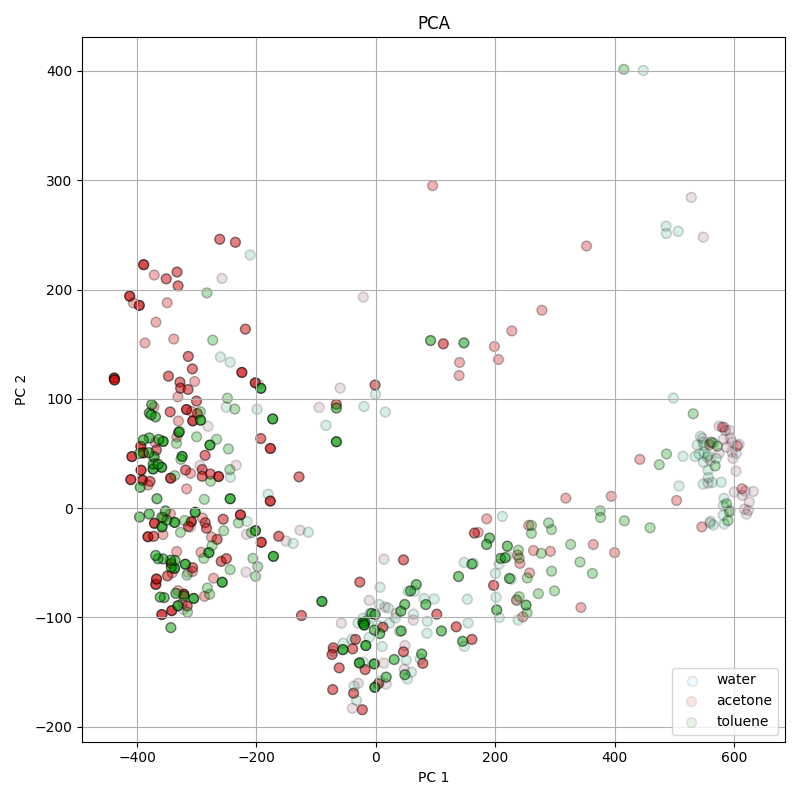

In [38]:
plt.close('all')
fig, ax = plt.subplots(figsize=(8, 8))
thisAx = ax
# thisAx.scatter(reduced_data[:, 0], reduced_data[:, 1], 
#                c=[pltClr[key] for key in np.argmax(yy_pca, axis=1)], 
#                marker='o', edgecolor='k', s=50, 
#                alpha = (200+np.sum(yy_pca, axis=1))/1000 
#               )
thisAx.scatter(reduced_data[np.where(np.argmax(yy_pca, axis=1) == 0)[0], 0], reduced_data[np.where(np.argmax(yy_pca, axis=1) == 0)[0], 1],
               c=pltClr[0], 
               marker='o', edgecolor='k', s=50, 
               alpha = .1
              )
for i in range(1,len(gasIdMap)):
    #print(i, sum(pulseSampleSize[:i-1]), sum(pulseSampleSize[:i]))
    alphaVec = ((100+np.sum(yy_pca, axis=1))/1000)[sum(pulseSampleSize[:i-1]):sum(pulseSampleSize[:i])]
    thisAx.scatter(reduced_data[sum(pulseSampleSize[:i-1]):sum(pulseSampleSize[:i]), 0], reduced_data[sum(pulseSampleSize[:i-1]):sum(pulseSampleSize[:i]), 1], 
                   c=pltClr[i], 
                   marker='o', edgecolor='k', s=50, 
                   alpha = alphaVec
                  )

thisAx.set_title('PCA')
thisAx.set_xlabel('PC 1')
thisAx.set_ylabel('PC 2')
thisAx.grid(True)

thisAx.legend([gasIdMap[key] for key in range(len(gasIdMap))], loc = "lower right")
fig.tight_layout()

#### PCA 3D Plot

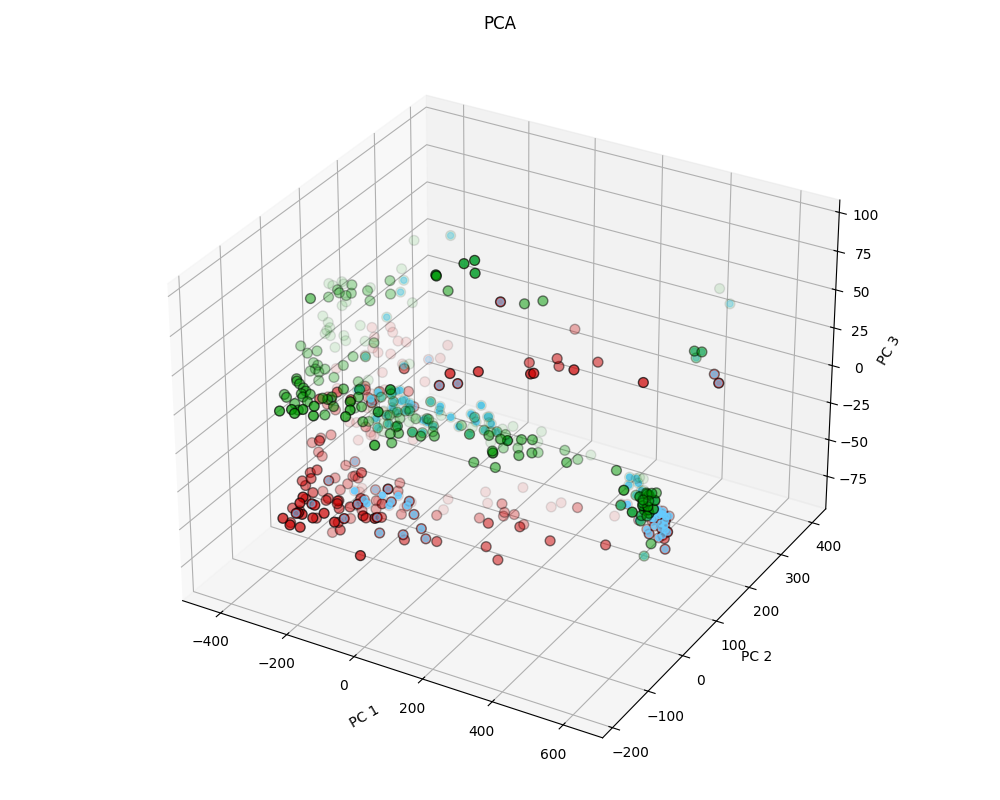

In [40]:
# Plot 3D plot
plt.close('all')
fig = plt.figure(figsize=(10,8))
thisAx = ax
thisAx = plt.axes(projection='3d')
thisAx.scatter3D(reduced_data[np.where(np.argmax(yy_pca, axis=1) == 0)[0], 0], 
             reduced_data[np.where(np.argmax(yy_pca, axis=1) == 0)[0], 1], 
             reduced_data[np.where(np.argmax(yy_pca, axis=1) == 0)[0], 2], 
             c=pltClr[0])
for i in range(1,len(gasIdMap)):
    #print(i, sum(pulseSampleSize[:i-1]), sum(pulseSampleSize[:i]))
    alphaVec = ((100+np.sum(yy_pca, axis=1))/1000)[sum(pulseSampleSize[:i-1]):sum(pulseSampleSize[:i])]
    thisAx.scatter3D(reduced_data[sum(pulseSampleSize[:i-1]):sum(pulseSampleSize[:i]), 0], 
                     reduced_data[sum(pulseSampleSize[:i-1]):sum(pulseSampleSize[:i]), 1], 
                     reduced_data[sum(pulseSampleSize[:i-1]):sum(pulseSampleSize[:i]), 2], 
                   c=pltClr[i], 
                   marker='o', edgecolor='k', s=50, 
                   alpha = alphaVec
                  )

thisAx.set_title('PCA')
thisAx.set_xlabel('PC 1', rotation=30)
thisAx.set_ylabel('PC 2')
thisAx.set_zlabel('PC 3', rotation=60)
fig.tight_layout()

### T-SNE

In [41]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=3, random_state=42)
reduced_data = tsne.fit_transform(xx_pca)


#### T-SNE 2D Plot

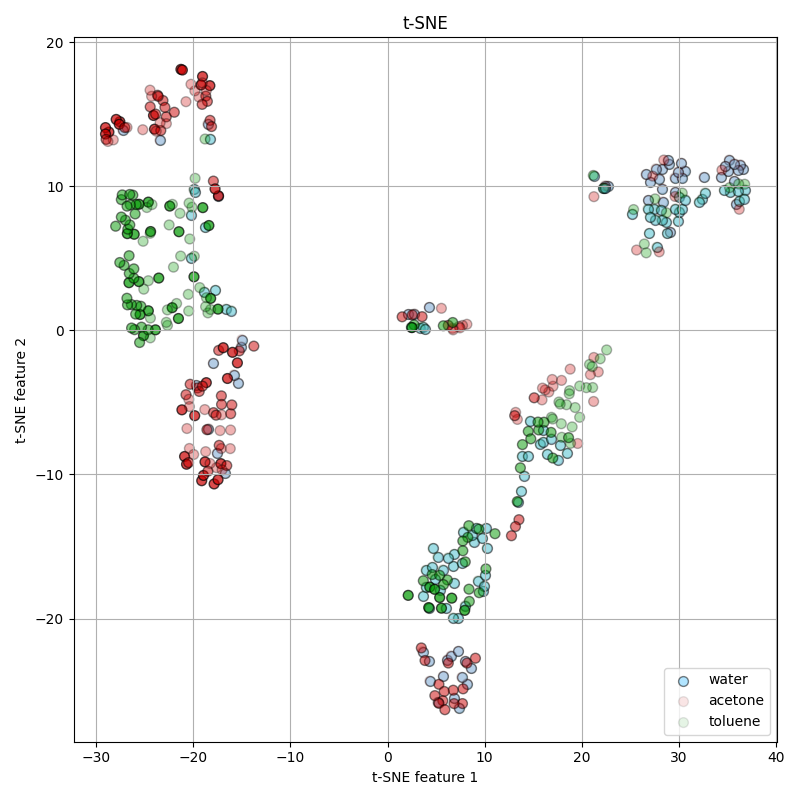

In [36]:
plt.close('all')
fig, ax = plt.subplots(figsize=(8, 8))
thisAx = ax
# thisAx.scatter(reduced_data[:, 0], reduced_data[:, 1], 
#                c=[pltClr[key] for key in np.argmax(yy_pca, axis=1)], 
#                marker='o', edgecolor='k', s=50, 
#                alpha = (200+np.sum(yy_pca, axis=1))/1000 
#               )
thisAx.scatter(reduced_data[np.where(np.argmax(yy_pca, axis=1) == 0)[0], 0], reduced_data[np.where(np.argmax(yy_pca, axis=1) == 0)[0], 1],
               c=pltClr[0], 
               marker='o', edgecolor='k', s=50, 
               alpha = .5
              )
for i in range(1,len(gasIdMap)):
    #print(i, sum(pulseSampleSize[:i-1]), sum(pulseSampleSize[:i]))
    alphaVec = ((100+np.sum(yy_pca, axis=1))/1000)[sum(pulseSampleSize[:i-1]):sum(pulseSampleSize[:i])]
    thisAx.scatter(reduced_data[sum(pulseSampleSize[:i-1]):sum(pulseSampleSize[:i]), 0], reduced_data[sum(pulseSampleSize[:i-1]):sum(pulseSampleSize[:i]), 1], 
                   c=pltClr[i], 
                   marker='o', edgecolor='k', s=50, 
                   alpha = alphaVec
                  )

thisAx.set_title('t-SNE')
thisAx.set_xlabel('t-SNE feature 1')
thisAx.set_ylabel('t-SNE feature 2')
thisAx.grid(True)

legend = thisAx.legend([gasIdMap[key] for key in range(len(gasIdMap))], loc = "lower right")

fig.tight_layout()

#### T-SNE 3D Plot

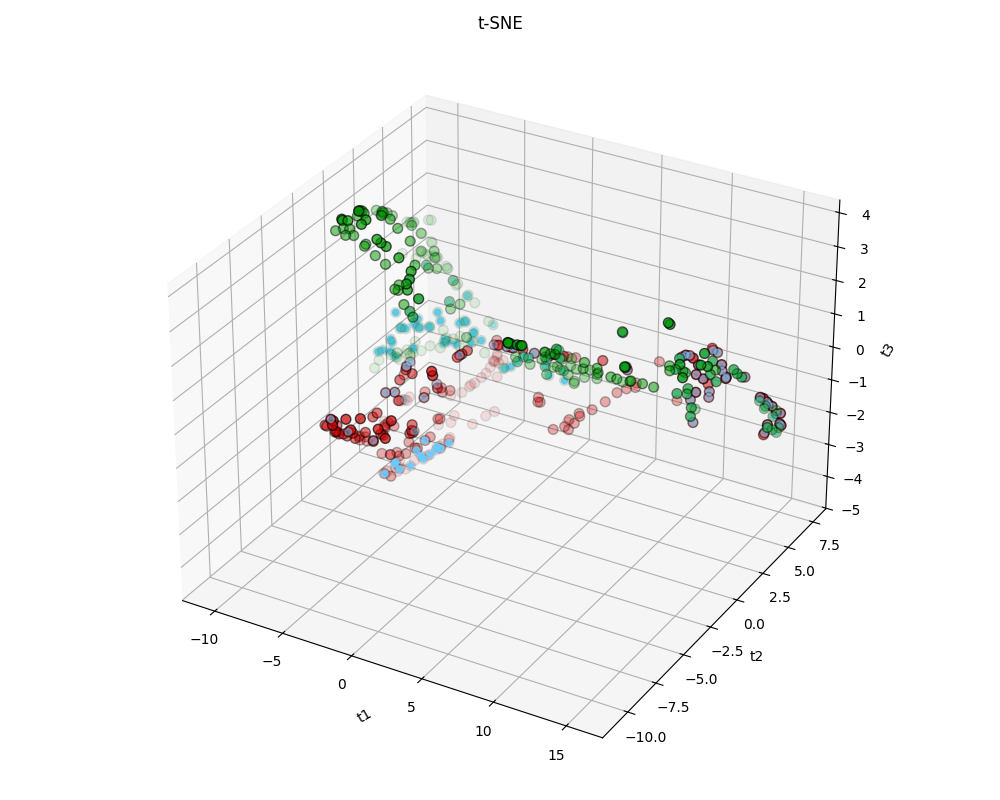

In [44]:
# Plot 3D plot
plt.close('all')
fig = plt.figure(figsize=(10,8))
thisAx = ax
thisAx = plt.axes(projection='3d')
thisAx.scatter3D(reduced_data[np.where(np.argmax(yy_pca, axis=1) == 0)[0], 0], 
             reduced_data[np.where(np.argmax(yy_pca, axis=1) == 0)[0], 1], 
             reduced_data[np.where(np.argmax(yy_pca, axis=1) == 0)[0], 2], 
             c=pltClr[0], 
             label=gasIdMap[0],
             )
for i in range(1,len(gasIdMap)):
    #print(i, sum(pulseSampleSize[:i-1]), sum(pulseSampleSize[:i]))
    alphaVec = ((100+np.sum(yy_pca, axis=1))/1000)[sum(pulseSampleSize[:i-1]):sum(pulseSampleSize[:i])]
    thisAx.scatter3D(reduced_data[sum(pulseSampleSize[:i-1]):sum(pulseSampleSize[:i]), 0], 
                     reduced_data[sum(pulseSampleSize[:i-1]):sum(pulseSampleSize[:i]), 1], 
                     reduced_data[sum(pulseSampleSize[:i-1]):sum(pulseSampleSize[:i]), 2], 
                   c=pltClr[i], 
                   marker='o', edgecolor='k', s=50, 
                   alpha = alphaVec, 
                   #label=gasIdMap[i],
                  )

thisAx.set_title('t-SNE')
thisAx.set_xlabel('t1', rotation=30)
thisAx.set_ylabel('t2')
thisAx.set_zlabel('t3', rotation=60)
#thisAx.legend()
fig.tight_layout()